In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mglearn
import pandas as pd
import pylab as plot
import lmfit as lf
import random
import seaborn as sns

%matplotlib inline

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter(action='ignore')

pd.options.display.float_format = '{:,.2g}'.format

C:\Users\63917\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)
C:\Users\63917\Anaconda3\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


**Framework:**
* EDA - look for inconsistencies wrt competition
* Total lost money for Outcome = 0
    * Calculate Sum of (Amount * [(APR-Cost of Fund)/100] * (Term/12))
* Targeting & Segmentation (James)
    Cluster by Loan Terms
    - inconsistent outcome
    - low outcome
* Maximize interest (best combination of term & APR to make outcome = 1) - ML Model (Elijah, Angela, Ria)
* Simulate declined to recalculate potential profit

Your task is to help Nomis Solutions to study and explore e-Car's data and to help them highlight potential inefficiencies in e-Car's current model and convince the company that there was value to be captured. 

Guide on approaching the task:

* Perform exploratory data analysis.
* How will you show that the current pricing technique contains "pricing errors"?
    * How do we know that there are "pricing errors"? What are we trying to maximize in this project?
* How can we make the analysis more manageable? Should we segment the customers?
* How should we price the loans? 
    * Do you think you can recommend the right price to quote?
    * Has there been a mis-pricing of APR quotes?
* Can we build a systematic approach that can scale with the number of segments given certain customer characteristics?

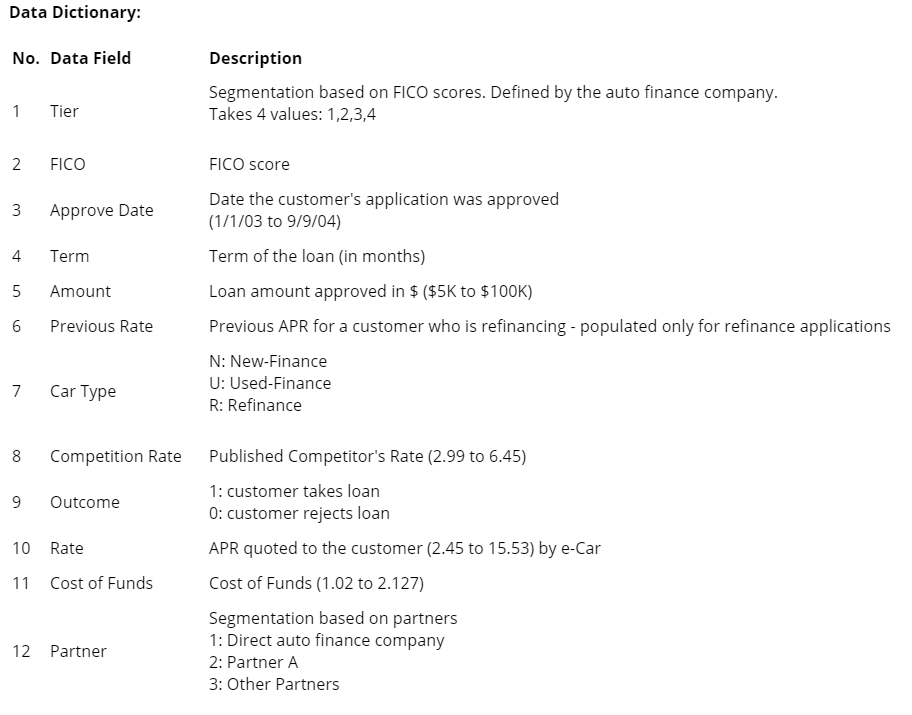

In [6]:
df = pd.read_excel("NomisB.xlsx", na_values=' ')

### Data Segmentation by Car Types

In [162]:
df_N = df[df['Car  Type']=='N']

In [193]:
df_U = df[df['Car  Type']=='U']
df_U = df_U.fillna(0)
df_U = pd.get_dummies(df_U, columns=['Partner Bin'])
df_U = df_U.drop(columns=['Approve Date', 'Car  Type', 'Previous Rate'])
df_U.head()
df_U_target = df_U['Outcome']
df_U_features = df_U.drop('Outcome', axis=1)

In [195]:
df_R = df[df['Car  Type']=='R']
df_R = df_R.fillna(0)
df_R = pd.get_dummies(df_R, columns=['Partner Bin'])
df_R = df_R.drop(columns=['Approve Date', 'Car  Type'])
df_R.head()
df_R_target = df_R['Outcome']
df_R_features = df_R.drop('Outcome', axis=1)

In [26]:
import random
df_a = df_N[df_N['Outcome']==0].reset_index()
data_pts = df_a.shape[0]
rand_pts = random.sample(range(data_pts), 9000)
df_a = df_a.iloc[rand_pts]
df_b = df_N[df_N['Outcome']==1].reset_index()
data_pts = df_b.shape[0]
rand_pts = random.sample(range(data_pts), 9000)
df_b = df_b.iloc[rand_pts]
df_b.head()
df_N = df_a.append(df_b).reset_index().drop(['level_0','index'], axis=1)

In [163]:
df_N = df_N.fillna(0)
df_N.shape

(119059, 12)

In [164]:
df_N = pd.get_dummies(df_N, columns=['Partner Bin'])

In [165]:
df_N = df_N.drop(columns=['Approve Date', 'Car  Type', 'Previous Rate'])

In [166]:
df_N.head()

,Tier,FICO,Term,Amount,Competition rate,Outcome,Rate,Cost of Funds,Partner Bin_1,Partner Bin_2,Partner Bin_3
0,1,743,36,1.9e+04,5,1,4.8,1.8,1,0,0
1,1,752,60,3.6e+04,5.7,1,5.5,1.8,1,0,0
3,2,724,60,1.9e+04,5.7,1,5.4,1.8,0,0,1
4,2,700,72,2.4e+04,6.2,1,7,1.8,0,0,1
8,1,779,72,2e+04,6.2,1,6.6,1.8,1,0,0


In [167]:
df_N_target = df_N['Outcome']

In [168]:
df_N_features = df_N.drop(columns='Outcome')

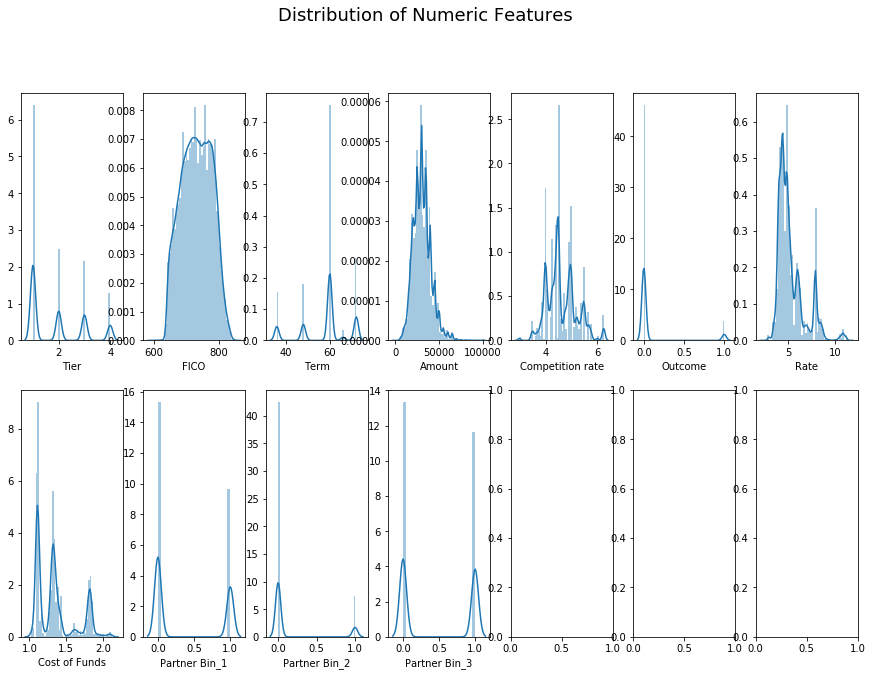

In [169]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=7, figsize=(15, 10))
for i, column in enumerate(df_N.columns):
    sns.distplot(df_N[column],ax=axes[i//7,i%7])
    plt.suptitle('Distribution of Numeric Features', fontsize=18, y=1)

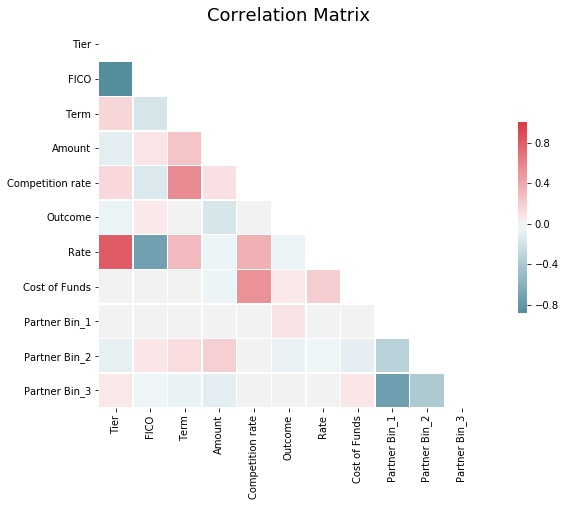

In [170]:
# Compute the correlation matrix
corr = df_N.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(14, 7))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5});
ax.axes.set_title("Correlation Matrix", fontsize=18, y=1.01);

### Testing of ML algorithms

In [17]:
def knn_class(n_iter, n_nbrs, t_size, df_feat, df_target, best_feat_how=None, scaler=None, **best_feat_kwargs):
    N = n_iter
    train_accuracy_list = []
    test_accuracy_list = []
    for i in range(N):
        X_train, X_test, y_train, y_test = train_test_split(df_feat, df_target, test_size=t_size)
        
        if scaler == 'ss':
            scale = StandardScaler()
            X_train = scale.fit_transform(X = X_train)
            X_test = scale.transform(X = X_test)
        elif scaler == 'mm':
            scale = MinMaxScaler()
            X_train = scale.fit_transform(X_train)
            X_test = scale.transform(X_test)
        else:
            pass
        
        training_accuracy = []
        test_accuracy = []
        neighbors_settings = range(1, min(n_nbrs, len(X_train)))

        for n_neighbors in neighbors_settings:
            # build the model
            clf = KNeighborsClassifier(n_neighbors=n_neighbors)
            clf.fit(X_train, y_train)

            # record training set accuracy
            training_accuracy.append(clf.score(X_train, y_train))

            # record generalization accuracy
            test_accuracy.append(clf.score(X_test, y_test))

        train_accuracy_list.append(training_accuracy)
        test_accuracy_list.append(test_accuracy)

    pass
    train_mean = np.array(train_accuracy_list).mean(axis=0)
    train_stdev = np.array(train_accuracy_list).std(axis=0)/np.sqrt(N)

    test_mean = np.array(test_accuracy_list).mean(axis=0)
    test_stdev = np.array(test_accuracy_list).std(axis=0)/np.sqrt(N)


    neighbors_settings_max = np.argmax(test_mean)+1
    test_mean_max = np.round(np.max(test_mean), 4)
    if not(best_feat_how):
        return ['KNN Classifier', test_mean_max*100, f'k = {neighbors_settings_max}', scaler]
    else:
        acc_best = 0 if best_feat_how=='indiv' else 100
        feat_best = 'placeholder'
        for feat in df_feat.columns:
            cols = [feat,] if best_feat_how=='indiv' else [i for i in df_feat.columns if i!=feat]
            niters = best_feat_kwargs.get('n_iter_best_feat', n_iter)
            nnbrs = best_feat_kwargs.get('n_nbrs_best_feat', n_nbrs)
            result = knn_class(niters, nnbrs, 
                             0.25, df_feat[cols], df_target)
            if (result[1]>acc_best and best_feat_how=='indiv') or (result[1]<acc_best and best_feat_how=='without'):
                acc_best = result[1]
                feat_best = feat
                
        return ['KNN Classifier', test_mean_max*100, f'k = {neighbors_settings_max}', scaler, feat_best]

In [125]:
knn_class(10, 30, 0.25, df_N_features, df_N_target, best_feat_how=None)

['KNN Classifier', 75.44, 'k = 11', None]

In [171]:
def pcc(df_target):
    target_count = np.unique(df_target, return_counts=True)[1]
    pcc_125 = np.round(1.25*np.sum((target_count/target_count.sum())**2), 4)
    return pcc_125

In [196]:
pcc(df_R_target)

0.6618

In [43]:
def logistic(df_feat, df_target, n_iter, t_size, reg, scaler, top_feats=1):
    C = [1e-8, 1e-4, 1e-3, 1e-2, 0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 5, 10, 15,  20, 100, 300, 1000, 5000]

    score_train = []
    score_test = []
    random_states = random.sample(range(100), n_iter)
    
    best_feats = {i:np.zeros(len(df_feat.columns)) for i in C}
    best_inter = {i:0 for i in C}
    for seed in random_states:
        training_accuracy = []  
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(df_feat, df_target, test_size=t_size, random_state=seed)
        
        if scaler == 'ss':
            scale = StandardScaler()
            X_train = scale.fit_transform(X = X_train)
            X_test = scale.transform(X = X_test)
        elif scaler == 'mm':
            scale = MinMaxScaler()
            X_train = scale.fit_transform(X_train)
            X_test = scale.transform(X_test)
        else:
            pass
        
        for alpha_run in C:
            lr = LogisticRegression(C=alpha_run, penalty=reg).fit(X_train, y_train)
            training_accuracy.append(lr.score(X_train, y_train))
            test_accuracy.append(lr.score(X_test, y_test))
            if scaler:
                coefs = np.mean(lr.coef_, axis=0)
                inter = np.mean(lr.intercept_, axis=0)
                best_feats[alpha_run] += coefs / n_iter
                best_inter[alpha_run] += inter / n_iter
#                 best_feats[alpha_run].append(df_feat.columns[np.argmax(np.abs(coefs))])
                
        score_train.append(training_accuracy)
        score_test.append(test_accuracy)
    score = np.mean(score_test, axis=0)
    feat_coeffs = best_feats[C[np.argmax(score)]]
    intercept = best_inter[C[np.argmax(score)]]

    if scaler:
        return [f'Logistic {reg}', np.round(np.amax(score)*100, 4), f'C = {C[np.argmax(score)]}', scaler,
                list(zip(df_feat.columns[np.argsort(np.abs(feat_coeffs))[-top_feats:][::-1]],
                         feat_coeffs[np.argsort(np.abs(feat_coeffs))[-top_feats:][::-1]])), (feat_coeffs, intercept)]
    else:
        return [f'Logistic {reg}', np.round(np.amax(score)*100, 4), f'C = {C[np.argmax(score)]}', scaler]



In [283]:
n = logistic(df_N_features, df_N_target, 20, 0.25, 'l1', 'mm', top_feats=10)

In [284]:
n

['Logistic l1',
 92.3476,
 'C = 3',
 'mm',
 [('Amount', -9.098392587704907),
  ('Rate', -3.4135979440681745),
  ('Term', 1.8046593255352945),
  ('Cost of Funds', 1.086797954491032),
  ('FICO', -0.663274598966211),
  ('Partner Bin_2', -0.5807589355467511),
  ('Tier', -0.39555558541910035),
  ('Partner Bin_1', 0.3437602061753951),
  ('Competition rate', -0.17793518989959722),
  ('Partner Bin_3', -0.1215966566339388)],
 (array([-0.39555559, -0.6632746 ,  1.80465933, -9.09839259, -0.17793519,
         -3.41359794,  1.08679795,  0.34376021, -0.58075894, -0.12159666]),
  -0.04370093455394698)]

### Simulate Logistic Regression

In [285]:
def y_func(coeff, inter, X):
    return np.dot(X,coeff.T) + inter    

In [286]:
coeff = n[5][0]
inter = n[5][1]

In [287]:
X = df_N_features.to_numpy()
X = MinMaxScaler().fit_transform(X)
X

array([[0.        , 0.57751938, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.6124031 , 0.66666667, ..., 1.        , 0.        ,
        0.        ],
       [0.33333333, 0.50387597, 0.66666667, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.66666667, 0.63953488, 0.66666667, ..., 1.        , 0.        ,
        0.        ],
       [0.33333333, 0.44573643, 0.33333333, ..., 0.        , 1.        ,
        0.        ],
       [0.66666667, 0.76356589, 0.66666667, ..., 0.        , 0.        ,
        1.        ]])

In [288]:
y = y_func(coeff, inter, X)
y

array([-2.02880516, -2.70801419, -1.63324091, ..., -3.02602811,
       -4.11357686, -2.80025046])

In [289]:
def p(y):
    return 1/(1+np.exp(-y))

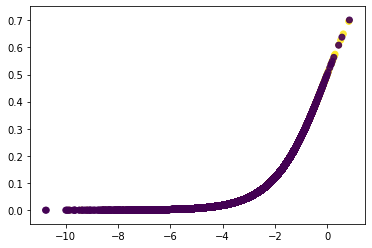

In [290]:
plt.scatter(y, p(y), c=df_N_target.to_numpy(), alpha=0.9)

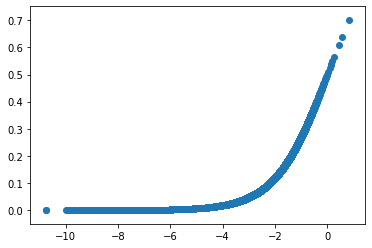

In [291]:
c=[df_N_target.to_numpy()==0]
plt.scatter(y[c], p(y)[c])

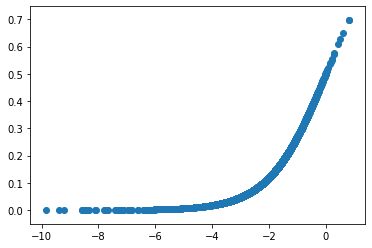

In [292]:
c=[df_N_target.to_numpy()==1]
plt.scatter(y[c], p(y)[c])

$\hat{y} = $
	<br>$-9.135 x Amount$
	<br>$-3.426 x Rate$
	<br>$+1.811 x Term$
	<br>$+1.096 x Cost of Funds$
	<br>$-0.665 x FICO$
	<br>$-0.622 x Partner Bin_2$
	<br>$-0.388 x Tier$
	<br>$+0.312 x Partner Bin_1$
	<br>$-0.188 x Competition rate$
	<br>$-0.151 x Partner Bin_3$
	<br>$+0.037$

In [246]:
print('$\hat{y} = $')
for i,j in list(zip(df_N_features.columns[np.argsort(np.abs(coeff))[::-1]],
         coeff[np.argsort(np.abs(coeff))[::-1]])):
    print(f'<br>${j:.3f} x {i}$')
print(f'\t{inter:.3f}')

$\hat{y} = $
<br>$-9.135 x Amount$
<br>$-3.426 x Rate$
<br>$1.811 x Term$
<br>$1.096 x Cost of Funds$
<br>$-0.665 x FICO$
<br>$-0.622 x Partner Bin_2$
<br>$-0.388 x Tier$
<br>$0.312 x Partner Bin_1$
<br>$-0.188 x Competition rate$
<br>$-0.151 x Partner Bin_3$
	0.037


Text(0.5, 1.0, 'Logit Probability Distribution of Availed vs Rejected Loans')

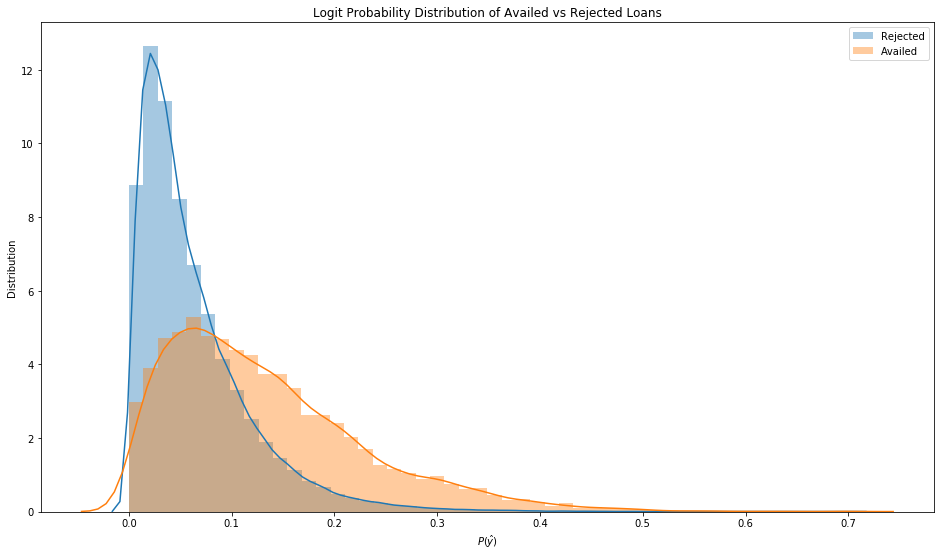

In [293]:
import seaborn as sns
fig = plt.figure(figsize=(16,9))
c0=[df_N_target.to_numpy()==0]
c1=[df_N_target.to_numpy()==1]
sns.distplot(p(y)[c0], label='Rejected')
sns.distplot(p(y)[c1], label='Availed')
plt.legend()
plt.xlabel('$P(\hat{y})$')
plt.ylabel('Distribution')
plt.title('Logit Probability Distribution of Availed vs Rejected Loans')
#sns.distplot(p(y))

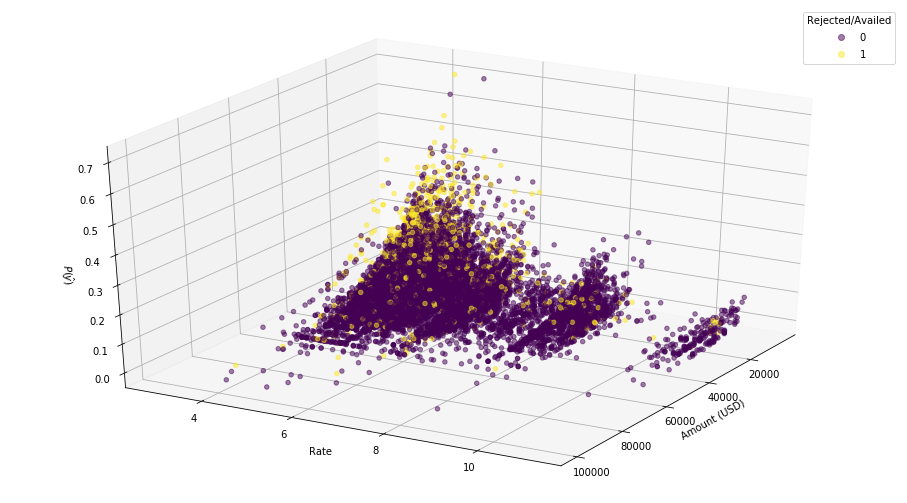

In [294]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16,9))
ax = plt.axes(projection='3d')
rand = random.sample(range(len(y)),18000)
ax1 = ax.scatter3D(df_N_features['Amount'].to_numpy()[rand], df_N_features['Rate'].to_numpy()[rand], p(y)[rand],
             c=df_N_target.to_numpy()[rand], alpha=0.5)
ax.view_init(azim=30)
ax.set_xlabel('Amount (USD)')
ax.set_ylabel('Rate')
ax.set_zlabel('$P(\hat{y})$')
ax.legend(*ax1.legend_elements(), title='Rejected/Availed');

Text(0.5, 1.0, 'Shifted Logit Probability Distribution of Rejected Loans')

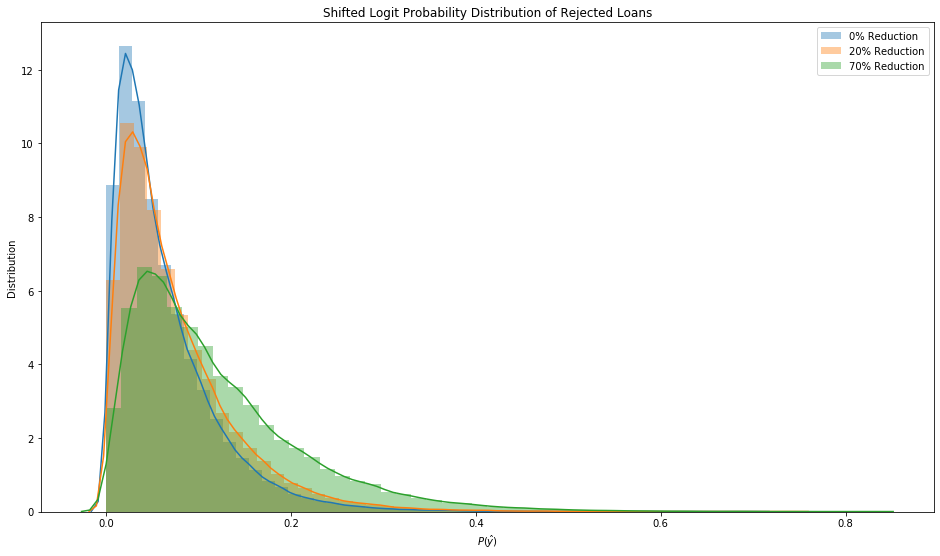

In [295]:
fig = plt.figure(figsize=(16,9))
ratedel = [0, 20, 70]
c0=[df_N_target.to_numpy()==0]
c1=[df_N_target.to_numpy()==1]
for r in ratedel:
    x = df_N_features.to_numpy()
    x = MinMaxScaler().fit_transform(x)
    x[:,df_N_features.columns.values.tolist().index('Rate')] *= (100-r)/100
    ypr = y_func(coeff, inter, x)
    sns.distplot(p(ypr)[c0], label=str(r)+'% Reduction')

plt.legend()
plt.xlabel('$P(\hat{y})$')
plt.ylabel('Distribution')
plt.title('Shifted Logit Probability Distribution of Rejected Loans')

In [197]:
u = logistic(df_U_features, df_U_target, 20, 0.25, 'l1', 'mm', top_feats=10)

In [296]:
coeff = u[5][0]
inter = u[5][1]
X = df_U_features.to_numpy()
X = MinMaxScaler().fit_transform(X)
y = y_func(coeff, inter, X)

In [297]:
print('$\hat{y} = $')
for i,j in list(zip(df_N_features.columns[np.argsort(np.abs(coeff))[::-1]],
         coeff[np.argsort(np.abs(coeff))[::-1]])):
    print(f'<br>${j:.3f} x {i}$')
print(f'\t{inter:.3f}')

$\hat{y} = $
<br>$-13.024 x Amount$
<br>$-9.702 x Rate$
<br>$1.989 x Term$
<br>$1.924 x Partner Bin_1$
<br>$1.749 x Tier$
<br>$1.546 x Partner Bin_3$
<br>$1.362 x Competition rate$
<br>$1.043 x Partner Bin_2$
<br>$-1.010 x FICO$
<br>$-0.193 x Cost of Funds$
	1.279


$\hat{y} = $
<br>$-13.024 x Amount$
<br>$-9.702 x Rate$
<br>$+1.989 x Term$
<br>$+1.924 x Partner Bin_1$
<br>$+1.749 x Tier$
<br>$+1.546 x Partner Bin_3$
<br>$+1.362 x Competition rate$
<br>$+1.043 x Partner Bin_2$
<br>$-1.010 x FICO$
<br>$-0.193 x Cost of Funds$
<br>$+1.279$

Text(0.5, 1.0, 'Logit Probability Distribution of Availed vs Rejected Loans')

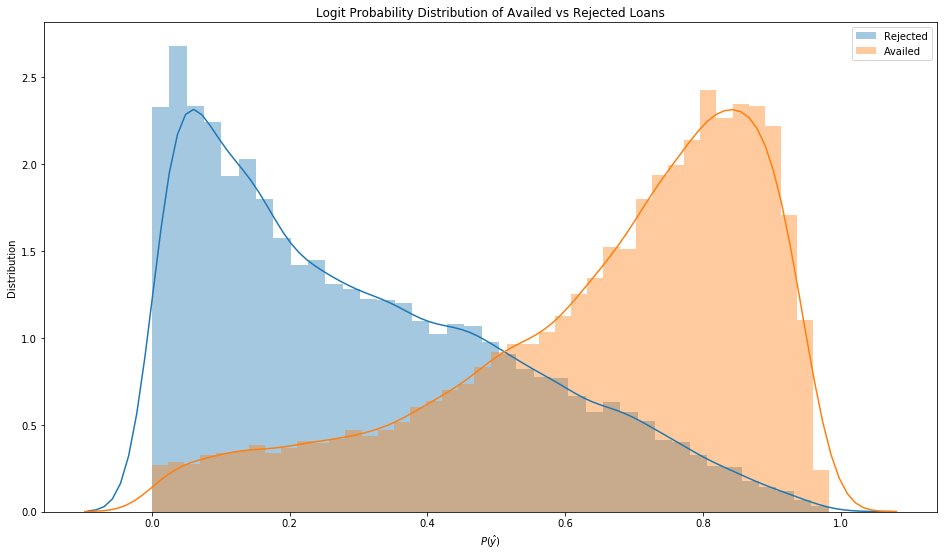

In [298]:
import seaborn as sns
fig = plt.figure(figsize=(16,9))
c0=[df_U_target.to_numpy()==0]
c1=[df_U_target.to_numpy()==1]
sns.distplot(p(y)[c0], label='Rejected')
sns.distplot(p(y)[c1], label='Availed')
plt.legend()
plt.xlabel('$P(\hat{y})$')
plt.ylabel('Distribution')
plt.title('Logit Probability Distribution of Availed vs Rejected Loans')
#sns.distplot(p(y))

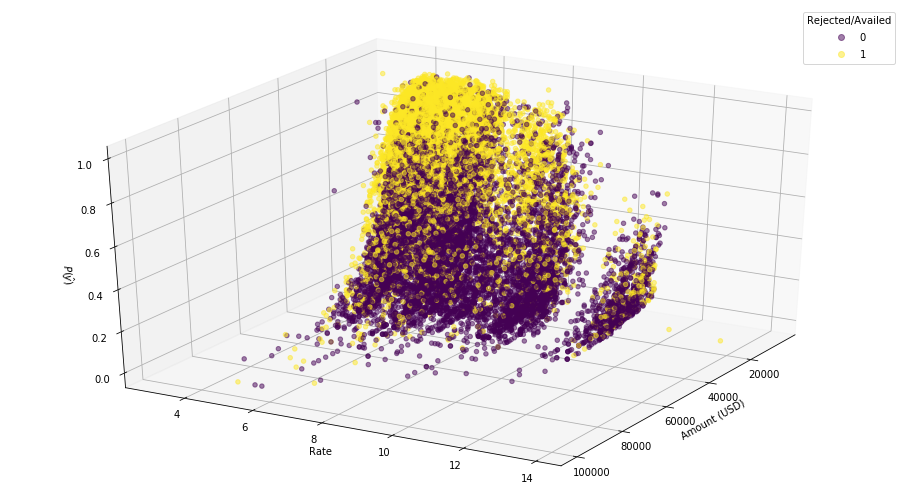

In [299]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16,9))
ax = plt.axes(projection='3d')
rand = random.sample(range(len(y)),18000)
ax1 = ax.scatter3D(df_U_features['Amount'].to_numpy()[rand], df_U_features['Rate'].to_numpy()[rand], p(y)[rand],
             c=df_U_target.to_numpy()[rand], alpha=0.5)
ax.view_init(azim=30)
ax.set_xlabel('Amount (USD)')
ax.set_ylabel('Rate')
ax.set_zlabel('$P(\hat{y})$')
ax.legend(*ax1.legend_elements(), title='Rejected/Availed');

Text(0.5, 1.0, 'Shifted Logit Probability Distribution of Rejected Loans')

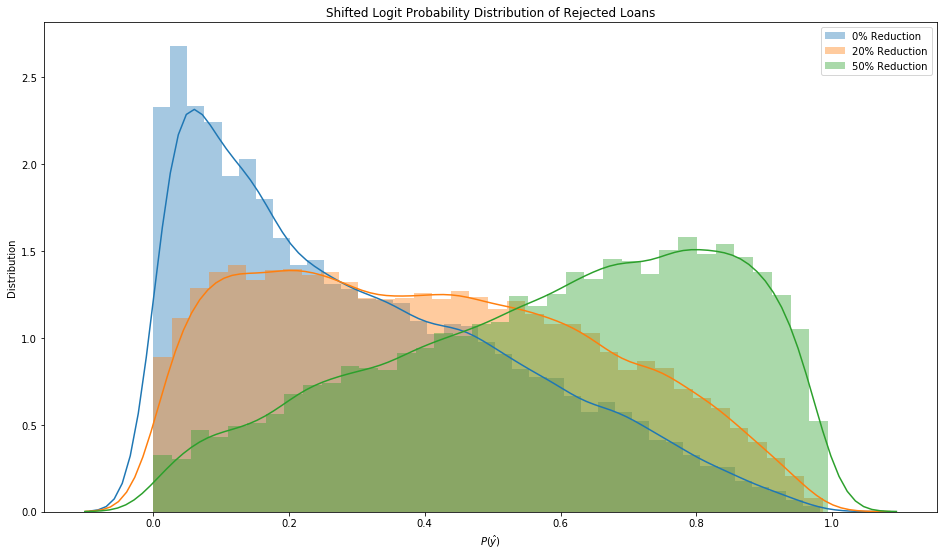

In [300]:
fig = plt.figure(figsize=(16,9))
ratedel = [0, 20, 50]
c0=[df_U_target.to_numpy()==0]
c1=[df_U_target.to_numpy()==1]
for r in ratedel:
    x = df_U_features.to_numpy()
    x = MinMaxScaler().fit_transform(x)
    x[:,df_U_features.columns.values.tolist().index('Rate')] *= (100-r)/100
    ypr = y_func(coeff, inter, x)
    sns.distplot(p(ypr)[c0], label=str(r)+'% Reduction')

plt.legend()
plt.xlabel('$P(\hat{y})$')
plt.ylabel('Distribution')
plt.title('Shifted Logit Probability Distribution of Rejected Loans')

In [302]:
r = logistic(df_R_features, df_R_target, 20, 0.25, 'l1', 'mm', top_feats=10)

In [303]:
coeff = r[5][0]
inter = r[5][1]
X = df_R_features.to_numpy()
X = MinMaxScaler().fit_transform(X)
y = y_func(coeff, inter, X)

In [306]:
print('$\hat{y} = $')
for i,j in list(zip(df_R_features.columns[np.argsort(np.abs(coeff))[::-1]],
         coeff[np.argsort(np.abs(coeff))[::-1]])):
    print(f'<br>${j:.3f} x {i}$')
print(f'<br>{inter:.3f}')

$\hat{y} = $
<br>$-5.366 x Rate$
<br>$4.230 x Previous Rate$
<br>$-2.067 x Amount$
<br>$-1.878 x FICO$
<br>$-1.078 x Partner Bin_2$
<br>$1.065 x Competition rate$
<br>$-0.803 x Tier$
<br>$0.646 x Partner Bin_1$
<br>$0.590 x Term$
<br>$0.455 x Cost of Funds$
<br>$0.432 x Partner Bin_3$
<br>0.082


$\hat{y} = $
<br>$-5.366 x Rate$
<br>$+4.230 x Previous Rate$
<br>$-2.067 x Amount$
<br>$-1.878 x FICO$
<br>$-1.078 x Partner Bin_2$
<br>$+1.065 x Competition rate$
<br>$-0.803 x Tier$
<br>$+0.646 x Partner Bin_1$
<br>$+0.590 x Term$
<br>$+0.455 x Cost of Funds$
<br>$+0.432 x Partner Bin_3$
<br>$+0.082$

Text(0.5, 1.0, 'Logit Probability Distribution of Availed vs Rejected Loans')

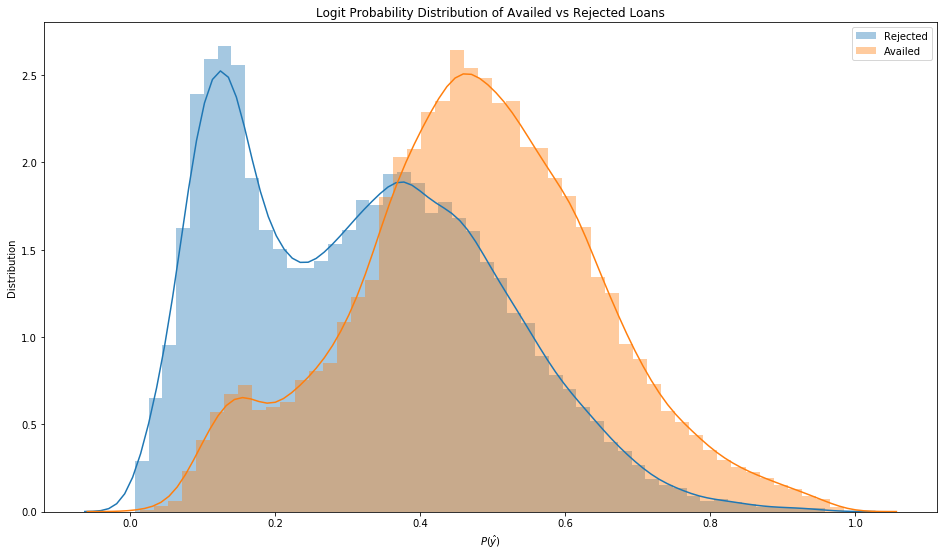

In [307]:
import seaborn as sns
fig = plt.figure(figsize=(16,9))
c0=[df_R_target.to_numpy()==0]
c1=[df_R_target.to_numpy()==1]
sns.distplot(p(y)[c0], label='Rejected')
sns.distplot(p(y)[c1], label='Availed')
plt.legend()
plt.xlabel('$P(\hat{y})$')
plt.ylabel('Distribution')
plt.title('Logit Probability Distribution of Availed vs Rejected Loans')
#sns.distplot(p(y))

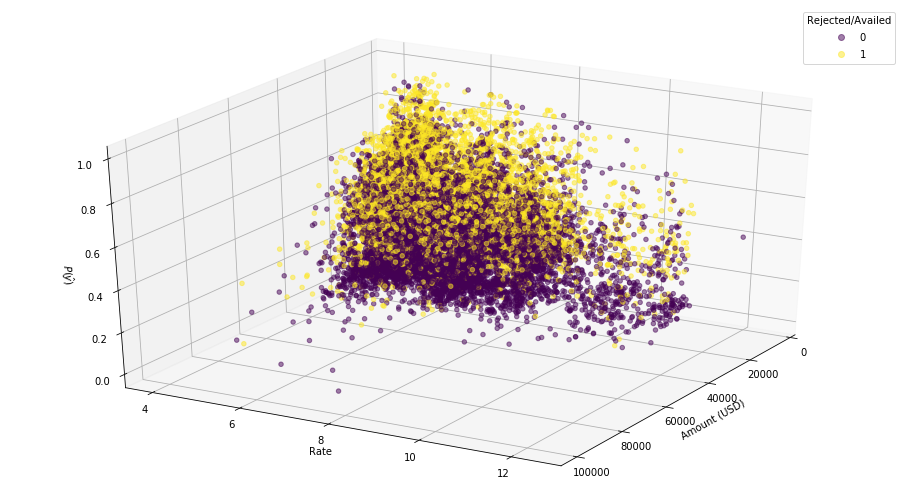

In [310]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(16,9))
ax = plt.axes(projection='3d')
rand = random.sample(range(len(y)),18000)
ax1 = ax.scatter3D(df_R_features['Amount'].to_numpy()[rand], df_R_features['Rate'].to_numpy()[rand], p(y)[rand],
             c=df_R_target.to_numpy()[rand], alpha=0.5)
ax.view_init(azim=30)
ax.set_xlabel('Amount (USD)')
ax.set_ylabel('Rate')
ax.set_zlabel('$P(\hat{y})$')
ax.legend(*ax1.legend_elements(), title='Rejected/Availed');

Text(0.5, 1.0, 'Shifted Logit Probability Distribution of Rejected Loans')

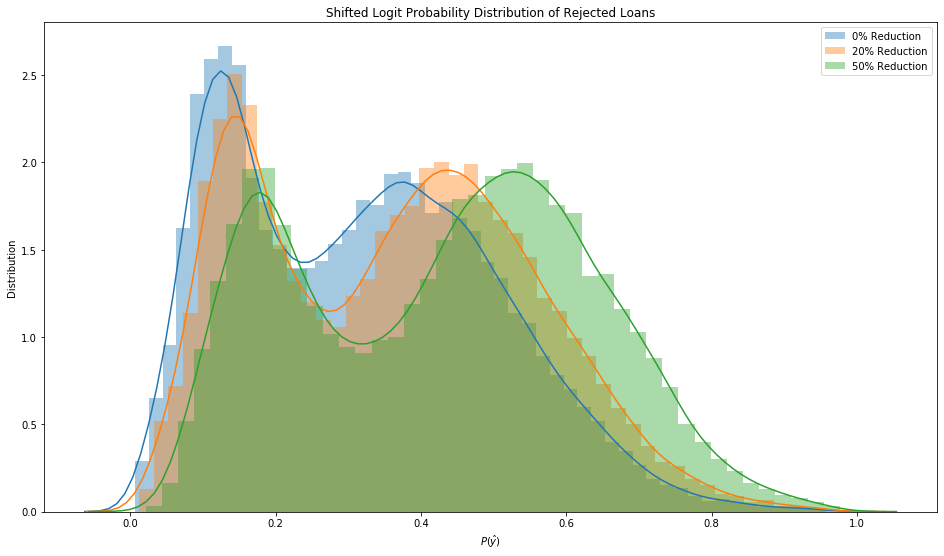

In [311]:
fig = plt.figure(figsize=(16,9))
ratedel = [0, 20, 50]
c0=[df_R_target.to_numpy()==0]
c1=[df_R_target.to_numpy()==1]
for r in ratedel:
    x = df_R_features.to_numpy()
    x = MinMaxScaler().fit_transform(x)
    x[:,df_R_features.columns.values.tolist().index('Rate')] *= (100-r)/100
    ypr = y_func(coeff, inter, x)
    sns.distplot(p(ypr)[c0], label=str(r)+'% Reduction')

plt.legend()
plt.xlabel('$P(\hat{y})$')
plt.ylabel('Distribution')
plt.title('Shifted Logit Probability Distribution of Rejected Loans')

In [38]:
def svm(df_feat, df_target, n_iter, t_size, reg, scaler, top_feats=1):
    C = [1e-8, 1e-4, 1e-3, 1e-2, 0.1, 0.2,0.4, 0.75, 1, 1.5, 3, 5, 10, 15,  20, 100, 300, 1000, 5000]

    score_train = []
    score_test = []
    random_states = random.sample(range(100), n_iter)
    best_feats = {i:np.zeros(len(df_feat.columns)) for i in C}
    for seed in random_states:
        training_accuracy = []  
        test_accuracy = []
        X_train, X_test, y_train, y_test = train_test_split(df_feat, df_target, test_size=t_size, random_state=seed)
        
        if scaler == 'ss':
            scale = StandardScaler()
            X_train = scale.fit_transform(X = X_train)
            X_test = scale.transform(X = X_test)
        elif scaler == 'mm':
            scale = MinMaxScaler()
            X_train = scale.fit_transform(X_train)
            X_test = scale.transform(X_test)
        else:
            pass

        for alpha_run in C:
            if reg == 'l1':
                svc = LinearSVC(C=alpha_run, penalty=reg, loss='squared_hinge', dual=False).fit(X_train, y_train)
            if reg == 'l2':
                svc = LinearSVC(C=alpha_run, penalty=reg).fit(X_train, y_train)
            training_accuracy.append(svc.score(X_train, y_train))
            test_accuracy.append(svc.score(X_test, y_test))
            if scaler:
                coefs = np.mean(svc.coef_, axis=0)
                best_feats[alpha_run] += coefs / len(random_states)

        score_train.append(training_accuracy)
        score_test.append(test_accuracy)
          
    score = np.mean(score_test, axis=0)
    feat_coeffs = best_feats[C[np.argmax(score)]]

    if scaler:
        return [f'SVM {reg}', np.round(np.amax(score)*100, 4), f'C = {C[np.argmax(score)]}', scaler, 
                list(zip(df_feat.columns[np.argsort(np.abs(feat_coeffs))[-top_feats:][::-1]],
                         feat_coeffs[np.argsort(np.abs(feat_coeffs))[-top_feats:][::-1]]))]
    else:
        return [f'SVM {reg}', np.round(np.amax(score)*100, 4), f'C = {C[np.argmax(score)]}', scaler]


In [39]:
svm(df_N_features, df_N_target, 20, 0.25, reg='l2', scaler='mm', top_feats=10)

['SVM l2',
 68.4522,
 'C = 3',
 'mm',
 [('Amount', -3.065494961160274),
  ('Rate', -1.2714260932964554),
  ('Term', 0.7058356945328085),
  ('Partner Bin_1', 0.4310965344476261),
  ('FICO', -0.3998762425772919),
  ('Cost of Funds', 0.39218462259885634),
  ('Partner Bin_3', 0.23468828579738202),
  ('Tier', -0.21411255364856285),
  ('Competition rate', -0.04678933472306601),
  ('Partner Bin_2', -0.026745927908751067)]]

In [40]:
svm(df_N_features, df_N_target, 20, 0.25, reg='l2', scaler='ss', top_feats=10)

['SVM l2',
 68.4933,
 'C = 3',
 'ss',
 [('Amount', -0.3300914100759237),
  ('Term', 0.21582348225869322),
  ('Rate', -0.18953171603578053),
  ('Cost of Funds', 0.09723813266559847),
  ('Partner Bin_2', -0.09400410081091995),
  ('Partner Bin_1', 0.07822553490922914),
  ('FICO', -0.07334792873898931),
  ('Tier', -0.0711939628256175),
  ('Partner Bin_3', -0.01971340167861528),
  ('Competition rate', -0.010391847535466682)]]

In [18]:
svm(df_N_features, df_N_target, 20, 0.25, reg='l2', scaler=None)

['SVM l2', 92.258, 'C = 0.1', None]

In [19]:
svm(df_N_features, df_N_target, 20, 0.25, reg='l1', scaler='mm')

['SVM l1', 92.3329, 'C = 1e-08', 'mm', 'FICO']

In [20]:
svm(df_N_features, df_N_target, 20, 0.25, reg='l1', scaler='ss')

['SVM l1', 92.3202, 'C = 1e-08', 'ss', 'FICO']

In [209]:
df_U_target.shape

(41816,)